In [1]:
from typing import List, Callable

import numpy as np
import matplotlib.pyplot as plt
import einops
import scipy.stats
import torch
from scipy.stats import rankdata, multivariate_normal, norm

In [2]:
from rank_hpo.core import sorted_exp_sample, infer_rates

In [3]:
np.random.seed(13)

In [4]:
eps_x = 1
eps_y = 1
N = 100
M = 10
jitter = np.random.normal(size=(N, M, 2)) * np.array([eps_x, eps_y]).reshape(1, 1, 2)
locs_x = np.linspace(0, 10, M)
locs = einops.rearrange(
    [locs_x, np.zeros_like(locs_x)], "i j -> 1 j i"
)
labels = einops.repeat(np.arange(M), "i -> b i 1", b=N)
samples = locs + jitter


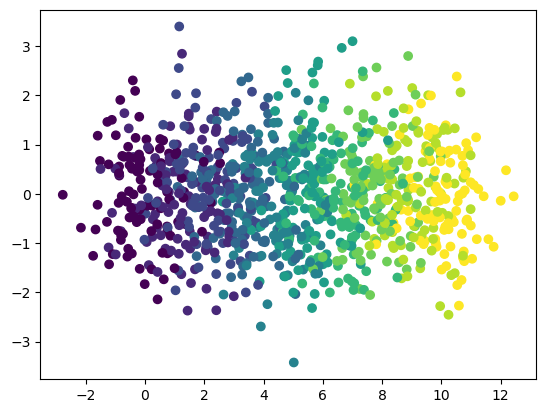

In [4]:
plt.scatter(samples[..., 0], samples[..., 1], c=labels, cmap="viridis")

Text(0, 0.5, 'objective 2 to be minimized')

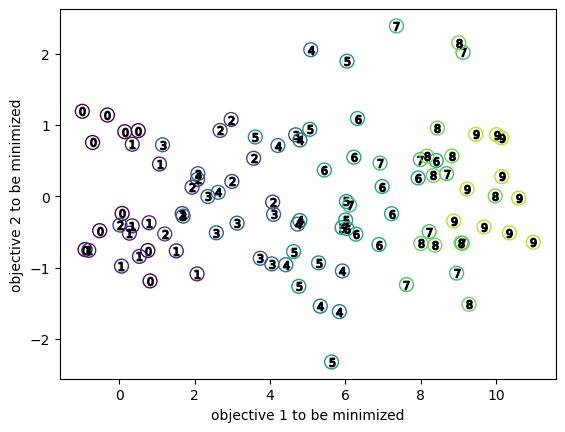

In [5]:
ax = plt.subplot()
cmap = plt.get_cmap("viridis")
for i in range(M):
    ax.scatter(samples[:10, i, 0], samples[:10, i, 1], s=100, facecolors='none', edgecolors=cmap(i/M))
    ax.scatter(samples[:10, i, 0], samples[:10, i, 1], marker=f"${i}$", color="black")

ax.set_xlabel("objective 1 to be minimized")
ax.set_ylabel("objective 2 to be minimized")

31.120534654687834


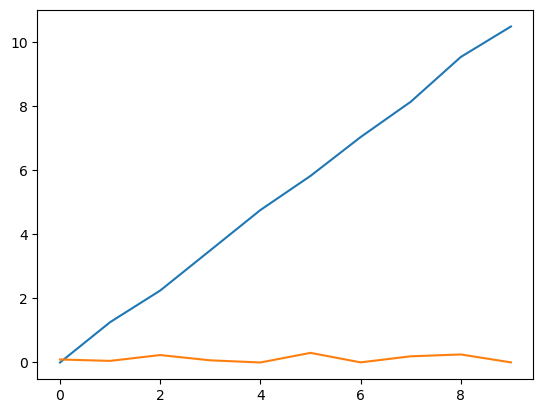

In [12]:
inferred_x = infer_rates([samples[:, i, 0] for i in range(M)], n_iter=1000)
inferred_y = infer_rates([samples[:, i, 1] for i in range(M)], n_iter=1000)
plt.plot(-np.log(inferred_x))
plt.plot(-np.log(inferred_y))
print(np.log(inferred_x).std()/np.log(inferred_y).std())

(-1.75, 2.25)

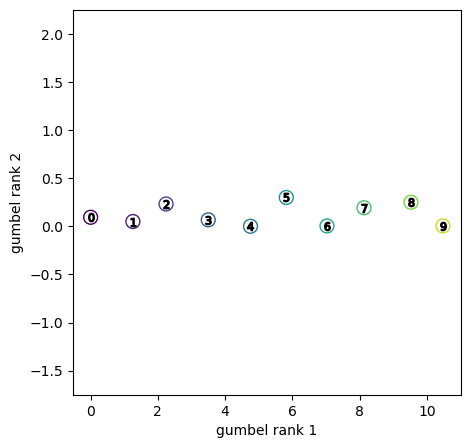

In [19]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
cmap = plt.get_cmap("viridis")
for i in range(M):
    ax.scatter(-np.log(inferred_x)[i], -np.log(inferred_y)[i], s=100, facecolors='none', edgecolors=cmap(i/M))
    ax.scatter(-np.log(inferred_x)[i], -np.log(inferred_y)[i], marker=f"${i}$", color="black")

ax.set_xlabel("gumbel rank 1")
ax.set_ylabel("gumbel rank 2")
ax.set_ylim((-1.75, 2.25))

Text(0.5, 1.0, 'Final Gumbel-Rank')

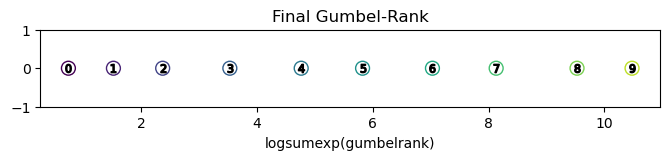

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8, 1))
cmap = plt.get_cmap("viridis")
for i in range(M):
    ax.scatter(np.log(1/inferred_x+1/inferred_y)[i],  np.zeros_like(inferred_x)[i], s=100, facecolors='none', edgecolors=cmap(i/M))
    ax.scatter(np.log(1/inferred_x+1/inferred_y)[i],  np.zeros_like(inferred_x)[i], marker=f"${i}$", color="black")

ax.set_xlabel("logsumexp(gumbelrank)")
ax.set_ylim((-1, 1))
ax.set_title("Final Gumbel-Rank")

15.244688099335312


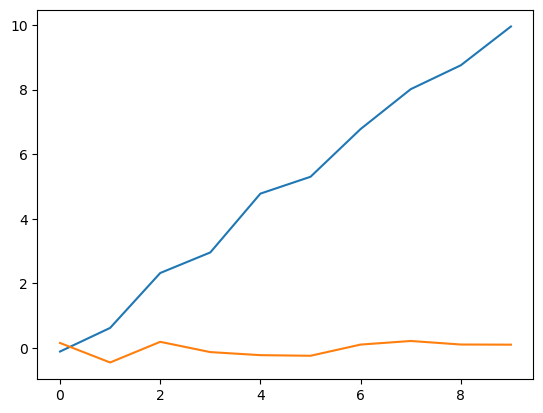

In [22]:
mean_x = np.array([samples[:10, i, 0].mean() for i in range(M)])
mean_y = np.array([samples[:10, i, 1].mean() for i in range(M)])
plt.plot(mean_x)
plt.plot(mean_y)
print(mean_x.std()/mean_y.std())

Text(0, 0.5, 'rank 2')

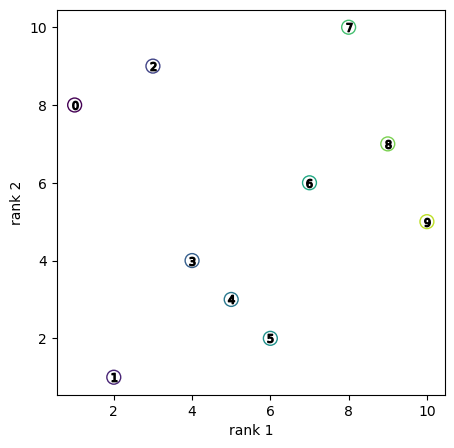

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
cmap = plt.get_cmap("viridis")
for i in range(M):
    ax.scatter(rankdata(mean_x)[i], rankdata(mean_y)[i], s=100, facecolors='none', edgecolors=cmap(i/M))
    ax.scatter(rankdata(mean_x)[i], rankdata(mean_y)[i], marker=f"${i}$", color="black")

ax.set_xlabel("rank 1")
ax.set_ylabel("rank 2")

In [24]:
np.argsort(np.stack([rankdata(mean_x), rankdata(mean_y)], axis=1).max(axis=1))

array([1, 3, 4, 5, 6, 0, 2, 8, 7, 9])

In [ ]:
def optimize_function_deterministic(function: Callable[[np.ndarray], float], x0s: List[np.ndarray], n_evals=1000, n_iter=1000, alpha=0.1):
    xs = np.stack(x0s, axis=0)
    ys = [function(x) for x in x0s]
    rates = np.ones(len(xs))
    mean = None
    cov = np.eye(len(xs[0]))+xs.T@xs/len(xs)
    for _ in range(n_evals):
        for _ in range(n_iter):
            order = rankdata(np.array(ys), method="ordinal") - 1
            latent_samples = sorted_exp_sample(rates, order, n_samples=1)
            if mean is None:
                weights = latent_samples.reshape([-1, 1])
            else:
                weights = (latent_samples.flatten() * multivariate_normal.pdf(xs, mean=mean, cov=cov)).reshape([-1, 1])
                weights /= weights.sum()
            mean = (weights * xs).sum(axis=0)
            new_cov = (1-alpha)*(
                (xs - mean[None, :]).T
                @ (weights * (xs - mean[None, :]))
            )+alpha*cov
            rv = multivariate_normal(mean=mean, cov=new_cov, allow_singular=False)
            rates = rv.pdf(xs)
        cov = new_cov
        x = rv.rvs(size=1).flatten()
        y = function(x)
        xs = np.concatenate([xs, x[None, :]], axis=0)
        ys = np.concatenate([ys, [y]])
        rates = rv.pdf(xs)
    return rv, xs, ys

def optimize_function(function: Callable[[np.ndarray], float], x0s: List[np.ndarray], n_evals=1000, n_iter=1000):
    xs = np.stack(x0s, axis=0)
    ys = [function(x) for x in x0s]
    rates = np.ones(len(xs))
    mean = None
    cov = None
    for _ in range(n_evals):
        print("** iter **")
        for _ in range(n_iter):
            order = rankdata(np.array(ys), method="ordinal") - 1
            latent_samples = sorted_exp_sample(rates, order, n_samples=1)
            weights = latent_samples.reshape([-1, 1]) / latent_samples.sum()
            if mean is None:
                mean = (weights * xs).sum(axis=0)
                cov = (
                    (xs - mean[None, :]).T
                    @ (weights * (xs - mean[None, :]))
                )
            else:
                i = np.argmax(np.log(weights)+np.random.gumbel(size=len(weights)))
                x_ = xs[i,:]
                scipy.stats.invwishart(df=len(xs), scale=cov+x_).rvs()
                mean = np.zeros_like(xs[0])
                cov = np.eye(len(xs[0]))+xs.T@xs/len(xs)
                new_mean = rv.rvs(size=1).flatten()
                weights = (latent_samples.flatten() * multivariate_normal.pdf(xs, mean=mean, cov=cov)).reshape([-1, 1])
                weights /= weights.sum()
                print(list(zip(xs.flatten().tolist(), latent_samples.flatten().tolist(), weights.flatten().tolist())))
                mean = (weights * xs).sum(axis=0)
                cov = (
                    (xs - mean[None, :]).T
                    @ (weights * (xs - mean[None, :]))
                )
                rv = multivariate_normal(mean=mean, cov=cov, allow_singular=False)
                rates = rv.pdf(xs)
        x = rv.rvs(size=1).flatten()
        y = function(x)
        xs = np.concatenate([xs, x[None, :]], axis=0)
        ys = np.concatenate([ys, [y]])
        rates = rv.pdf(xs)
    return rv, xs, ys


def optimize_function_deterministic(function: Callable[[np.ndarray], float], x0s: List[np.ndarray], n_evals=1000, n_iter=1000):
    xs = np.stack(x0s, axis=0)
    ys = [function(x) for x in x0s]
    rates = np.ones(len(xs))
    mean = np.zeros_like(xs[0])
    cov = np.eye(len(xs[0]))+xs.T@xs/len(xs)
    for _ in range(n_evals):
        for _ in range(n_iter):
            order = rankdata(np.array(ys), method="ordinal") - 1
            latent_samples = sorted_exp_sample(rates, order, n_samples=1)
            weights = 1-(latent_samples.flatten() * multivariate_normal.pdf(xs, mean=mean, cov=cov)).reshape([-1, 1])
            weights /= weights.sum()
            mean = (weights * xs).sum(axis=0)
            cov = (
                (xs - mean[None, :]).T
                @ (weights * (xs - mean[None, :]))
            )
            rv = multivariate_normal(mean=mean, cov=cov, allow_singular=False)
            rates = rv.pdf(xs)
        x = rv.rvs(size=1).flatten()
        y = function(x)
        xs = np.concatenate([xs, x[None, :]], axis=0)
        ys = np.concatenate([ys, [y]])
        rates = rv.pdf(xs)
    return rv, xs, ys

In [350]:
import torch
import math

def langevin_step(theta0: torch.Tensor, energy_func, step_size=1e-3, weight_decay=1e-4, temperature=1):
    theta = theta0.requires_grad_(True)
    if theta.grad is not None:
        theta.grad.zero_()
    energy = energy_func(theta)
    energy.backward()
    noise = torch.randn_like(theta)
    # if the grad is too large, clip it by shrinking the step size:
    if torch.norm(theta.grad) > 1:
        step_size /= torch.norm(theta.grad)
    theta.data -= step_size * theta.grad + math.sqrt(2*step_size) * noise * temperature
    # Do weight decay:
    theta.data -= weight_decay * theta.data
    return theta, np.linalg.norm(theta.grad)
    

def optimize_function_langevin(function: Callable[[np.ndarray], float], x0s: List[np.ndarray], log_rho, theta: torch.Tensor, n_evals=1000, n_iter=1000, weight_decay=1e-4, step_size=1e-3, n_langevin_steps=10, batch_size=100):
    x0s = [torch.tensor(x0, requires_grad=False) for x0 in x0s]
    xs = torch.stack(x0s, dim=0)
    ys = np.array([function(x.detach().numpy()).flatten() for x in x0s])
    rates = np.ones(len(xs))
    theta_grads = []
    x_grads = []
    latent_samples_log = []
    for i in range(n_evals):
        temperature = (n_evals-i)/n_evals
        for _ in range(n_iter):
            order = rankdata(np.nan_to_num(np.array(ys), nan=float("inf")), method="ordinal") - 1
            latent_samples = torch.tensor(sorted_exp_sample(rates, order, n_samples=1), requires_grad=False)
            latent_samples_log.append(latent_samples.flatten())
            theta = theta.requires_grad_(True)
            for _ in range(n_langevin_steps):
                # Choose a batch of xs:
                ixs = np.random.choice(len(ys), size=min(batch_size, len(ys)), replace=False)
                def energy_func(theta):
                    log_rho_xt = log_rho(xs[ixs].requires_grad_(False), theta)
                    return (torch.exp(log_rho_xt)*latent_samples[:, ixs] - log_rho_xt).sum()
                theta, grad = langevin_step(theta, energy_func, step_size=step_size, weight_decay=weight_decay, temperature=temperature)
                theta_grads.append(grad)
            rates = torch.exp(log_rho(xs, theta)).detach().numpy()
        # Sample from the distribution:
        # Seed x from the lowest temperature% of y values:
        n_ys = max(int(len(ys)*temperature), 1)
        best_ys = np.argsort(ys.flatten())[:n_ys]
        ix = np.random.choice(best_ys)
        x = xs[ix].detach().view([1, -1]).clone()
        x = x.requires_grad_(True)
        def energy_function(x):
            return -log_rho(x, theta.requires_grad_(False))
        for _ in range(n_iter):
            x, grad = langevin_step(x, energy_function, temperature=temperature)
            x_grads.append(grad)
        y = function(x.detach().numpy())
        xs = torch.concatenate([xs, x.detach().flatten()[None, :]], dim=0)
        ys = np.concatenate([ys, [y.flatten()]], axis=0)
        rates = torch.exp(log_rho(xs, theta)).detach().numpy()
    # Plot some diagnostics:
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    axs[0].plot(theta_grads, label="theta grads")
    axs[0].set_title("theta grads")
    axs[1].plot(x_grads, label="x grads")
    axs[1].set_title("x grads")
    # Plot a scatterplot of latent samples:
    sample_index = torch.concatenate([torch.ones_like(latent_samples_log[i])*i for i in range(len(latent_samples_log))], dim=0)
    latent_samples_log = torch.concatenate(latent_samples_log, dim=0)
    axs[2].scatter(sample_index, torch.log(latent_samples_log), alpha=0.1)
    fig.show()
    return theta, xs, ys

In [26]:
def function(x):
    return np.sum(x**2)

In [ ]:
rv, xs, ys = optimize_function_deterministic(function, [np.array([10]), np.array([-12]), np.array([5])], n_evals=100, n_iter=100)

In [ ]:
plt.plot(xs)

In [ ]:
plt.plot(np.linspace(-10, 10), rv.pdf(np.linspace(-10, 10)))

In [ ]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))

In [ ]:
np.random.seed(10)
time = np.linspace(1, 10)
y_mean = time*.5
y = y_mean + np.random.normal(size=len(time))
y_max = y_mean + 1
plt.box(False)

plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.plot(time, y, color="black")
plt.hlines(3, 0, 10, color="red", ls="--")
plt.text(4.2, 3.5, "time of first crossing", horizontalalignment='right')
# Place an x at the point (5, 5)
plt.scatter(4.2, 3, color="red", s=100, marker="x")

plt.text(10.2, y[-1], "final value", horizontalalignment='left')
# Place an x at the point (5, 5)
plt.scatter(10, y[-1], color="red", s=100, marker="x")

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)
for ax in axs:
    ax.plot(time, y, color="black")
    ax.hlines(3, 0, 10, color="red", ls="--")
    ax.set_axis_off()
    
    ax.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 

axs[0].plot(time, y_max, color="blue", ls=":")
axs[0].set_title("Model envelope")
axs[1].plot(time, y_mean, color="blue", ls=":")
axs[1].set_title("Model mean value")
axs[2].plot(time, y_mean + np.random.normal(size=len(time)), color="blue", ls=":")
axs[2].set_title("Model dynamics")

In [ ]:
np.random.seed(13)
xs_ = np.random.rand(100)
transx = lambda x: 0.5*x+3*x**3
xs = transx(xs_)
thrshx = transx(0.5)
ys_ = np.random.rand(100)
transy = lambda y: -np.log(1-y)
ys = transy(ys_)
thrshy = transy(0.5)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(xs, ys)
ax.set_xlabel("objective 1 to be minimized")
ax.set_ylabel("objective 2 to be minimized")
ax.hlines(thrshy, 0, xs.max(), color="red", ls="--")
ax.axvspan(thrshx, xs.max(), alpha=0.2, color="red")
ax.vlines(thrshx, 0, ys.max(), color="red", ls="--")
ax.axhspan(thrshy, ys.max(), alpha=0.2, color="red")

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].scatter(xs, ys)
axs[0].set_xlabel("objective 1 to be minimized")
axs[0].set_ylabel("objective 2 to be minimized")
axs[0].hlines(thrshy, 0, xs.max(), color="red", ls="--")
axs[0].axvspan(thrshx, xs.max(), alpha=0.2, color="red")
axs[0].vlines(thrshx, 0, ys.max(), color="red", ls="--")
axs[0].axhspan(thrshy, ys.max(), alpha=0.2, color="red")

axs[1].scatter(rankdata(xs), rankdata(ys))
axs[1].set_xlabel("rank 1")
axs[1].set_ylabel("rank 2")
axs[1].hlines(50, 0, 100, color="red", ls="--")
axs[1].axvspan(50, 100, alpha=0.2, color="red")
axs[1].vlines(50, 0, 100, color="red", ls="--")
axs[1].axhspan(50, 100, alpha=0.2, color="red")

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(rankdata(xs), rankdata(ys))
ax.set_xlabel("rank 1")
ax.set_ylabel("rank 2")
ax.hlines(50, 0, 100, color="red", ls="--")
ax.axvspan(50, 100, alpha=0.2, color="red")
ax.vlines(50, 0, 100, color="red", ls="--")
ax.axhspan(50, 100, alpha=0.2, color="red")

In [204]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

In [392]:
def optimize_function_sklearn(function: Callable[[np.ndarray], float], x0s: List[np.ndarray], n_evals=1000, n_iter=1000):
    xs = np.stack(x0s, axis=0)
    ys = [function(x) for x in x0s]
    rates = np.ones(len(xs))
    # mean = np.zeros_like(xs[0])
    # cov = np.eye(len(xs[0]))+xs.T@xs/len(xs)
    models = []
    for _ in range(n_evals):
        order = rankdata(np.array(ys), method="ordinal") - 1
        latent_samples = sorted_exp_sample(rates, order, n_samples=1)
        ys_ = -np.log(latent_samples.flatten().reshape([-1, 1]))
        model = GradientBoostingRegressor()
        model.fit(xs, ys_.ravel())
        # Find the largest prediction value by random sampling:
        jitter = np.random.normal(size=(len(xs)*n_iter, len(xs[0])), loc=0, scale=xs.std(axis=0))
        x_random = einops.repeat(
            xs, "i j -> (n_iter i ) j", n_iter=n_iter)+jitter
        x_random = x_random[:max(n_iter, len(xs)), :]
        i = np.argmax(model.predict(x_random)+np.random.gumbel(size=x_random.shape[0]))
        x = x_random[i]
        y = function(x)
        xs = np.concatenate([xs, x[None, :]], axis=0)
        ys = np.concatenate([ys, [y]])
        log_rates = -model.predict(xs)
        rates = np.exp(log_rates-log_rates.max())+1e-6
        models.append(model)
    return models, xs, ys

In [221]:
def function(x):
    return (x**2)+50*np.exp(-(x-.5)**2/20)+5*np.random.normal(size=x.shape)

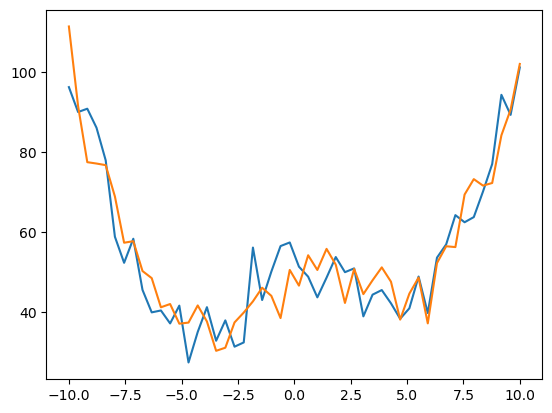

In [339]:
plt.plot(np.linspace(-10, 10), function(np.linspace(-10, 10)))
plt.plot(np.linspace(-10, 10), function(np.linspace(-10, 10)))

In [333]:
models, xs, ys = optimize_function_sklearn(function, [np.array([10]), np.array([-12]), np.array([5])], n_evals=100, n_iter=100)

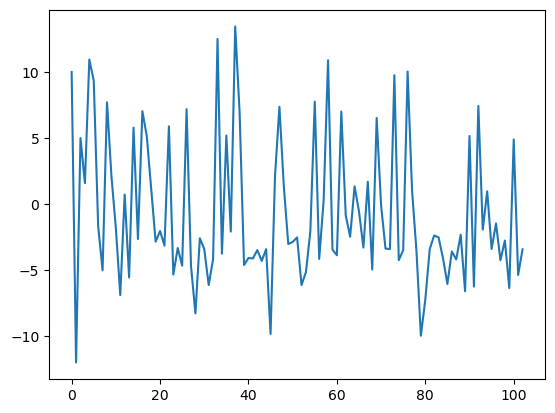

In [334]:
plt.plot(xs)

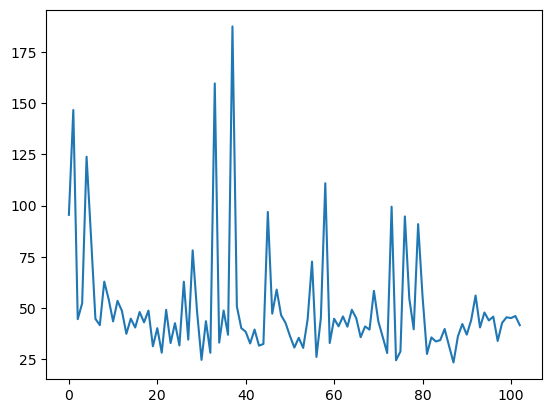

In [335]:
plt.plot(ys)

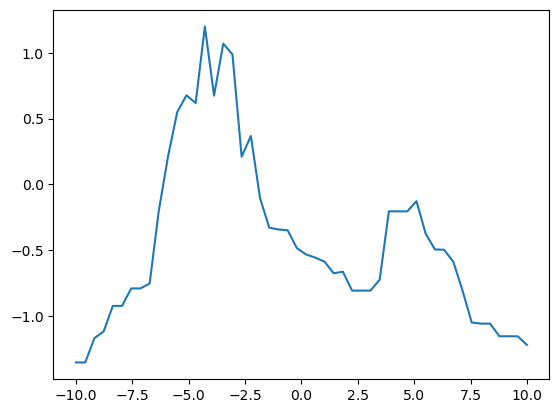

In [338]:
plt.plot(np.linspace(-10, 10), np.stack([
    model.predict(np.linspace(-10, 10)[:, None]) for model in models[:-30]], axis=1).mean(axis=1))

In [278]:
a = 1
b = 100
def rosenbrock(x, a=a, b=b):
    return (a-x[0])**2+b*(x[1]-x[0]**2)**2

In [288]:
np.random.seed(13)
models, xs, ys = optimize_function_sklearn(rosenbrock, [np.array([0, 0]), np.array([-3, 3]), np.array([5, 4])], n_evals=30, n_iter=100)

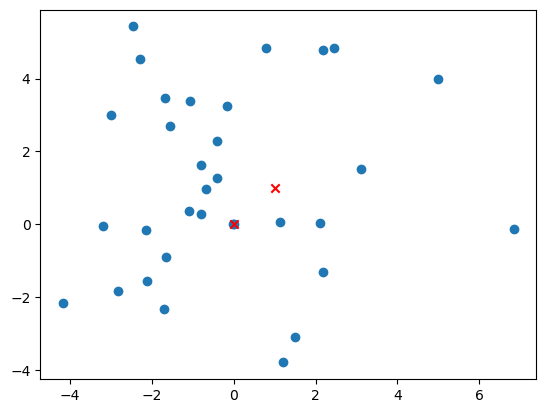

In [289]:
plt.scatter(xs[:,0], xs[:,1])
plt.scatter(a, a**2, color="red", marker="x")
# plot the smallest value:
plt.scatter(xs[ys.argmin(), 0], xs[ys.argmin(), 1], color="red", marker="x")

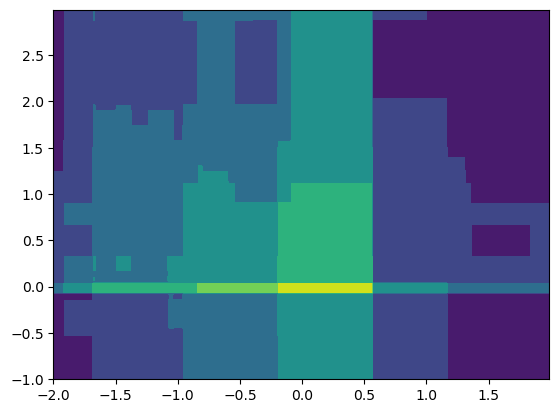

In [290]:
# plot a heatmap of the model:
x, y = np.mgrid[-2:2:.01, -1:3:.01]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, np.stack([model.predict(pos).reshape(x.shape) for model in models[:-10]], axis=1).mean(axis=1))


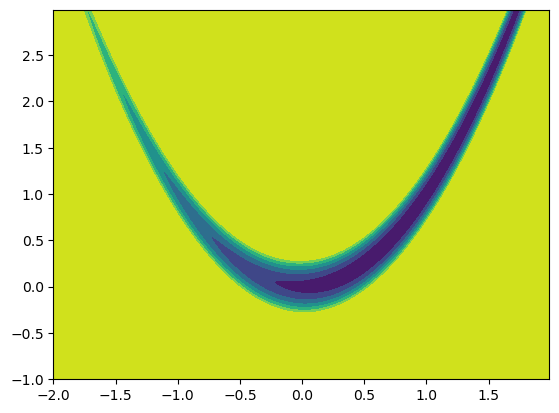

In [203]:
# plot a heatmap of the model:
x, y = np.mgrid[-2:2:.01, -1:3:.01]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, np.array([rosenbrock(pos[i]) for i in range(len(pos))]).reshape(x.shape).clip(max=10))

In [291]:
a = 1
b = 100
def noisy_pit(x, a=a, b=b):
    return (x[0]-1)**2+b*(x[1]-1)**2+np.random.normal()

In [295]:
np.random.seed(13)
models, xs, ys = optimize_function_sklearn(noisy_pit, [np.array([0, 0]), np.array([-3, 3]), np.array([5, 4])], n_evals=30, n_iter=100)

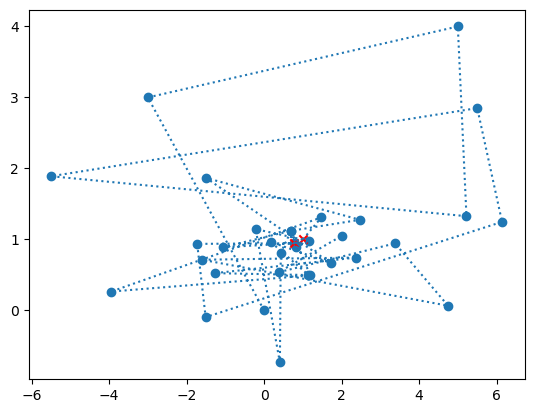

In [300]:
plt.scatter(xs[:,0], xs[:,1])
plt.scatter(a, a**2, color="red", marker="x")
# plot the smallest value:
plt.scatter(xs[ys.argmin(), 0], xs[ys.argmin(), 1], color="red", marker="x")
plt.plot(xs[:,0], xs[:,1], ls = ":")

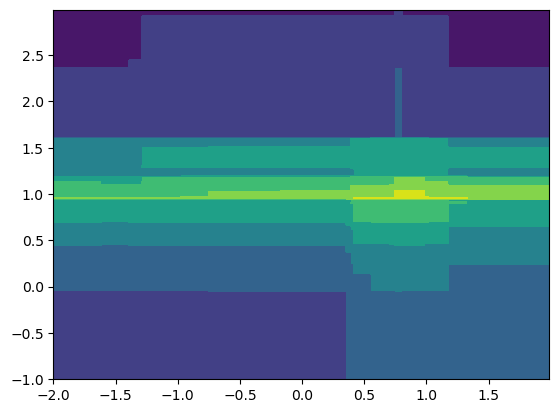

In [297]:
# plot a heatmap of the model:
x, y = np.mgrid[-2:2:.01, -1:3:.01]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, np.stack([model.predict(pos).reshape(x.shape) for model in models[:-10]], axis=1).mean(axis=1))

/var/folders/q6/pc7m262944l_scm7t626bn9c0000gn/T/ipykernel_96701/419016756.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


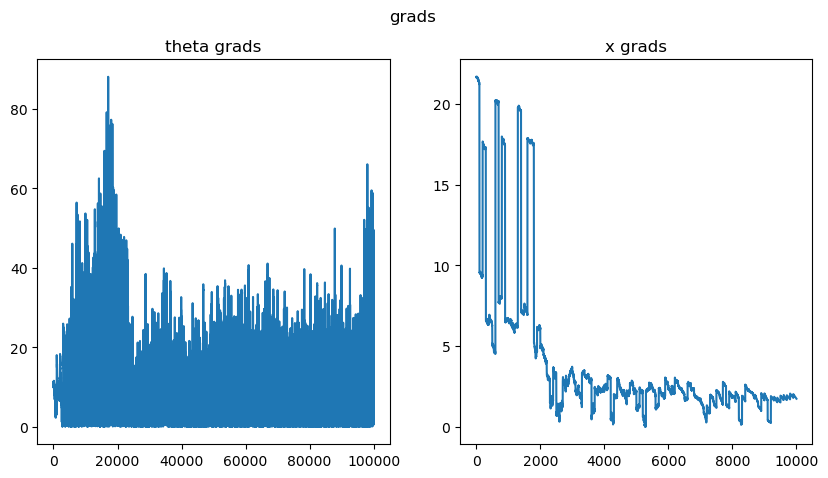

In [252]:
def log_rho(x, theta):
    return -torch.sum((x-theta.flatten()[None, :])**2, dim=1)

theta, xs, ys = optimize_function_langevin(
    function, [np.array([10.]), np.array([-12.]), np.array([5.]), np.array([-8.])], log_rho=log_rho, theta=torch.tensor([0.], requires_grad=True), n_evals=100, n_iter=100)

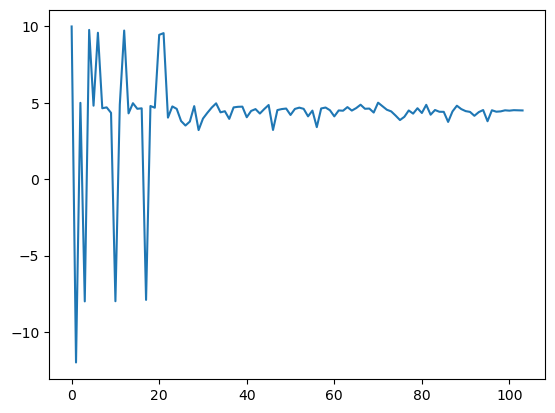

In [253]:
plt.plot(xs)

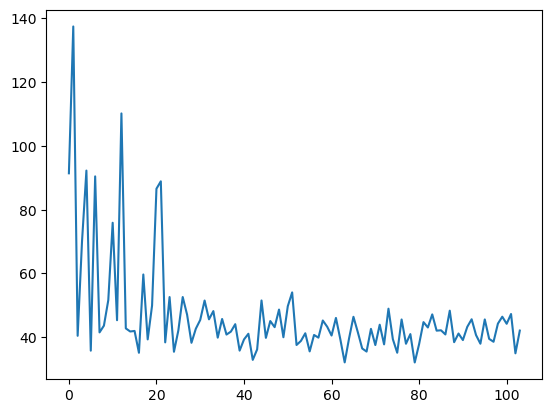

In [254]:
plt.plot(ys)

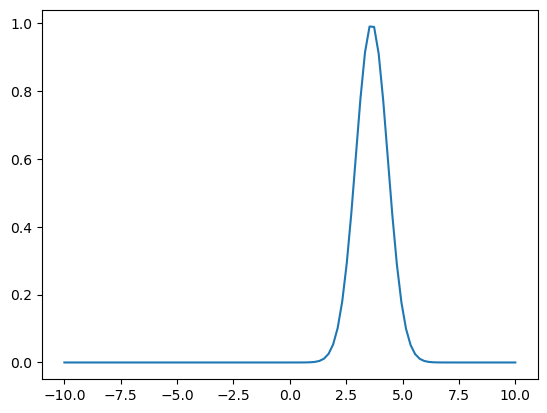

In [255]:
x_space = torch.linspace(-10, 10, 100).reshape(-1, 1)
p = torch.exp(log_rho(x_space, theta))
plt.plot(x_space, p)

In [366]:
langevin_step(torch.tensor([0, 0.], requires_grad=True), lambda theta: log_rho(torch.tensor([1, 1.]), theta), step_size=1e-3)

tensor([-2.], grad_fn=<NegBackward0>) tensor([0., 0.], requires_grad=True)


tensor([-0.0256,  0.0193], requires_grad=True)

In [358]:
x = torch.tensor([1, 1.]).clone().requires_grad_(True)
y = (x**2).sum()
y.backward()
x.grad

tensor([2., 2.])

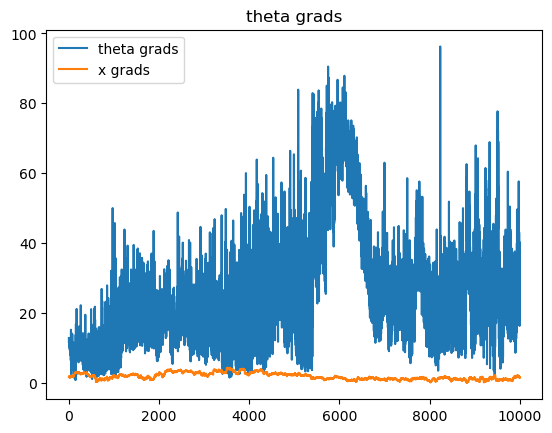

In [82]:
def log_rho(x, theta):
    # Theta is a 4-dimensional vector, the first two dimensions
    # are the mean of the distribution, the second two are the 
    # diagonal standard deviations of the distribution.
    mean, log_std = theta[:2].reshape(1, -1), theta[2:].reshape(1, -1)
    var = torch.sigmoid(2*log_std)
    return -torch.sum(0.5*(x-mean)**2/var, dim=1) - torch.sum(log_std, dim=1)

a = 1
b = 100
def rosenbrock(x, a=a, b=b):
    x = x.flatten()
    assert len(x) == 2
    return (a-x[0])**2+b*(x[1]-x[0]**2)**2

theta = torch.tensor([0., 0., 0, 0], requires_grad=True)

theta, xs, ys = optimize_function_langevin(rosenbrock, [np.array([0,0.]), np.array([-3., 3]), np.array([1,0.]), np.array([0, 1.])], 
                                           log_rho=log_rho, 
                                           theta=theta, n_evals=100, n_iter=100)

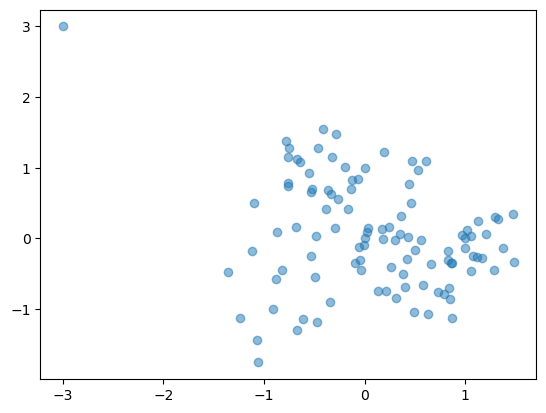

In [83]:
plt.scatter(xs[:,0], xs[:,1], alpha=0.5)

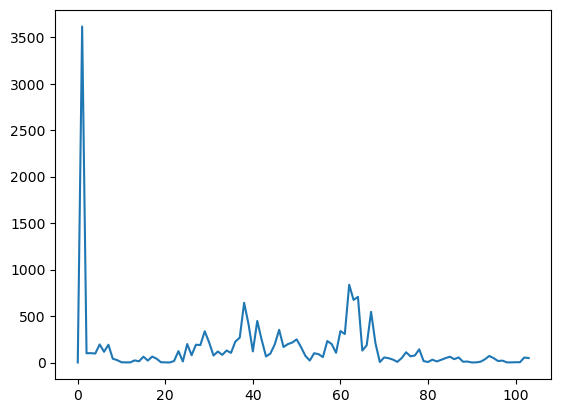

In [84]:
plt.plot(ys)

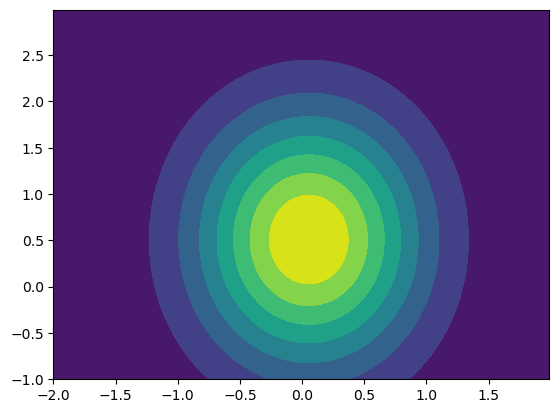

In [85]:
# plot a heatmap of the model:
x, y = np.mgrid[-2:2:.01, -1:3:.01]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, np.exp(log_rho(torch.tensor(pos), theta)).reshape(x.shape))

In [86]:
theta

tensor([ 0.0544,  0.5079, -0.2078,  1.1320])

/var/folders/q6/pc7m262944l_scm7t626bn9c0000gn/T/ipykernel_96701/419016756.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


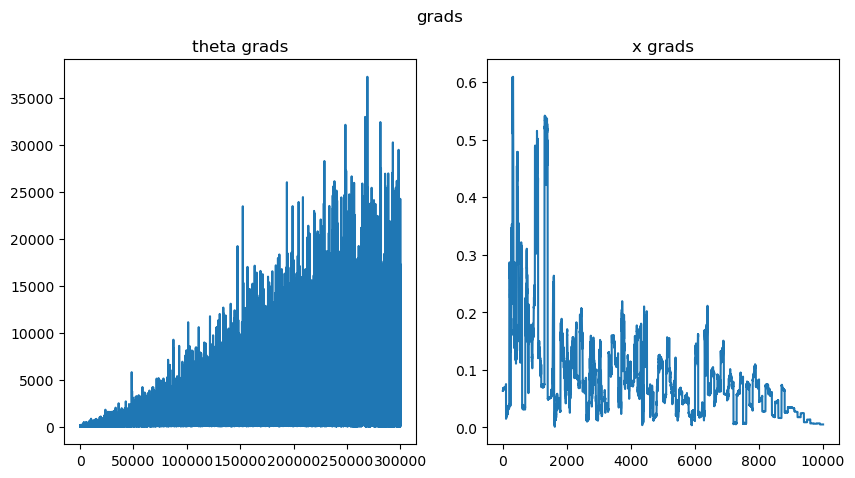

In [262]:
def log_rho(x, theta):
    """This is a simple 2-layer mlp units and tanh activation"""
    layer_1_weights = theta[:2]
    layer_1_bias = theta[2:3]
    layer_2_weights = theta[3:4]
    
    # layer_1 = torch.nn.functional.gelu(x@layer_1_weights+layer_1_bias)
    linear_1 = x@layer_1_weights+layer_1_bias
    linear_1 = torch.nn.functional.layer_norm(linear_1, normalized_shape=layer_1_weights.shape[1:])
    layer_1 = torch.tanh(linear_1)
    layer_2 = layer_1@layer_2_weights.T
    return layer_2 - (1e-4*x**2).sum(dim=1, keepdim=True)

a = 1
b = 100
def rosenbrock(x, a=a, b=b):
    x = x.flatten()
    assert len(x) == 2
    return (a-x[0])**2+b*(x[1]-x[0]**2)**2

theta = torch.tensor([0., 0., 0, 0], requires_grad=True)
ndim = 300
theta = torch.randn(size=(4, ndim), requires_grad=True, dtype=torch.double)
theta.data *= .02 / math.sqrt(ndim)

theta, xs, ys = optimize_function_langevin(rosenbrock, [np.array([0,0.]), np.array([-3., 3]), np.array([1,0.]), np.array([0, 1.])], 
                                           log_rho=log_rho, 
                                           theta=theta, n_evals=100, n_iter=100, weight_decay=1e-2, n_langevin_steps=30)

In [263]:
#theta

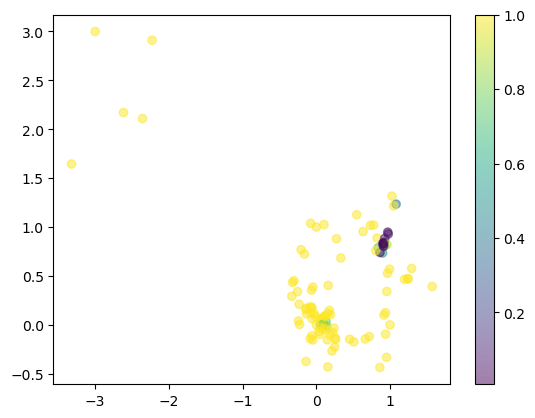

In [264]:
plt.scatter(xs[:, 0], xs[:,1], alpha=0.5, c=ys.clip(max=1))
plt.colorbar()

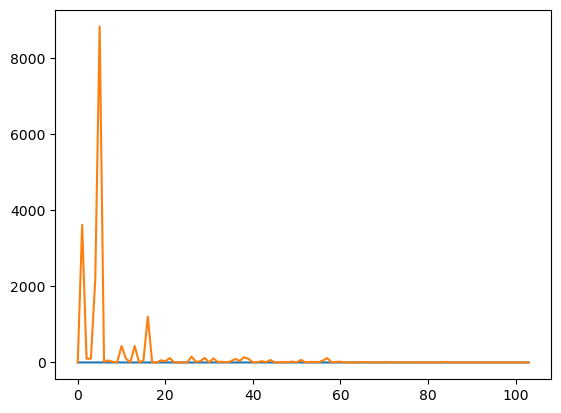

In [265]:
plt.plot(np.minimum.accumulate(ys))
plt.plot(ys)

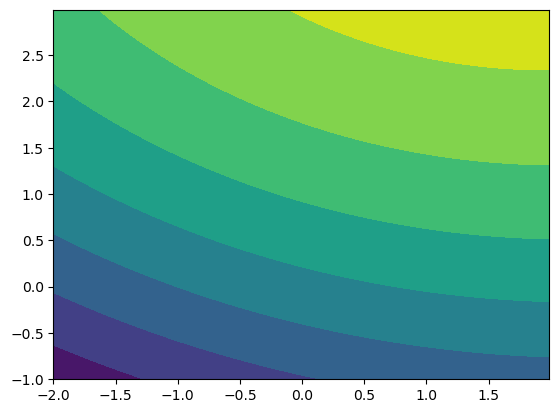

In [269]:
# plot a heatmap of the model:
x, y = np.mgrid[-2:2:.01, -1:3:.01]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, np.exp(log_rho(torch.tensor(pos), theta)).reshape(x.shape))

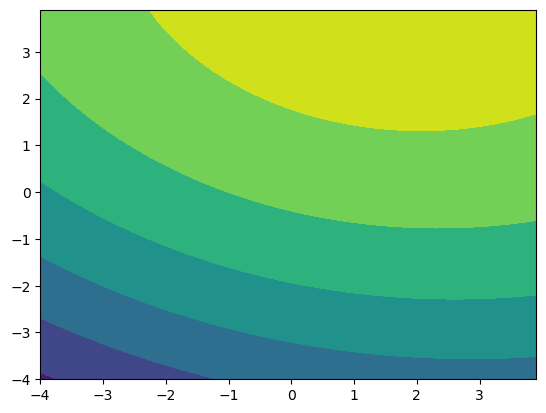

In [267]:
# plot a heatmap of the model:
x, y = np.mgrid[-4:4:.1, -4:4:.1]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, np.exp(log_rho(torch.tensor(pos), theta)).reshape(x.shape))

In [288]:
def gaussian_mixture_builder(grid: np.ndarray, std=1):
    """
    Builds a gaussian mixture model with gaussians centered at the
    grid points.
    
    Args:
        grid: The grid of points to center the gaussians at, of shape (n, d)
    """
    grid = torch.tensor(grid, dtype=torch.double, requires_grad=False)
    def log_rho(x, theta):
        """Theta is of shape (n, d), and represents the weight of each gaussian"""
        gaussians = -0.5*((x[:, None, :]-grid[None, :, :])**2).sum(dim=2)/(std**2) + theta[None, :]
        result = torch.logsumexp(gaussians, dim=1)
        # print(x.shape, grid.shape, theta.shape, result.shape)
        return result
    return log_rho


/var/folders/q6/pc7m262944l_scm7t626bn9c0000gn/T/ipykernel_96701/2774423922.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


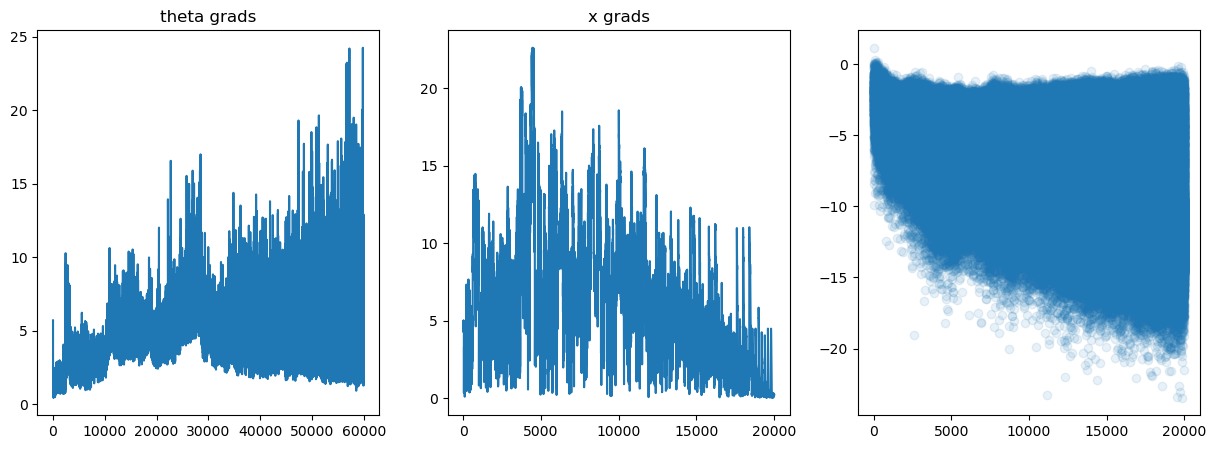

In [368]:
grid = np.mgrid[-2:2:.1, -2:2:.1].reshape(2, -1).T
log_rho = gaussian_mixture_builder(grid, std=.1)

a = 1
b = 100
def rosenbrock(x, a=a, b=b):
    x = x.flatten()
    assert len(x) == 2
    return (a-x[0])**2+b*(x[1]-x[0]**2)**2

theta = torch.zeros(size=(grid.shape[0],), requires_grad=True, dtype=torch.double)

theta, xs, ys = optimize_function_langevin(rosenbrock, np.random.randn(10, 2).tolist(), 
                                           log_rho=log_rho, 
                                           theta=theta, n_evals=100, n_iter=200, weight_decay=0, n_langevin_steps=3)

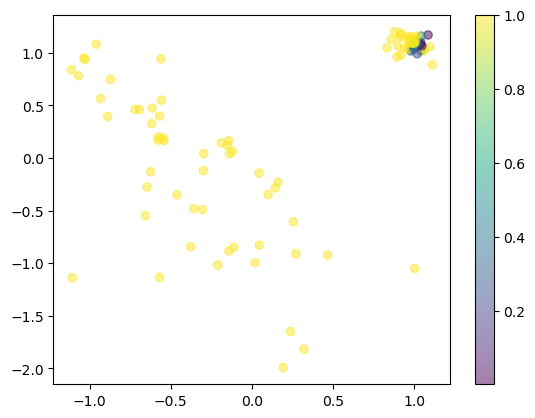

In [369]:
plt.scatter(xs[:, 0], xs[:,1], alpha=0.5, c=ys.clip(max=1))
plt.colorbar()

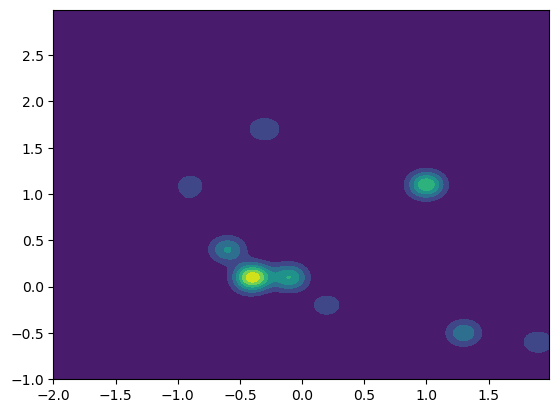

In [370]:
# plot a heatmap of the model:
x, y = np.mgrid[-2:2:.01, -1:3:.01]
pos = np.stack((x.flatten(), y.flatten()), axis=1)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, np.exp(log_rho(torch.tensor(pos), theta)).reshape(x.shape))

(array([  3.,  40., 110., 271., 407., 380., 247., 101.,  29.,  12.]),
 array([-12.44776718,  -9.95292127,  -7.45807535,  -4.96322944,
         -2.46838353,   0.02646238,   2.52130829,   5.0161542 ,
          7.51100012,  10.00584603,  12.50069194]),
 <BarContainer object of 10 artists>)

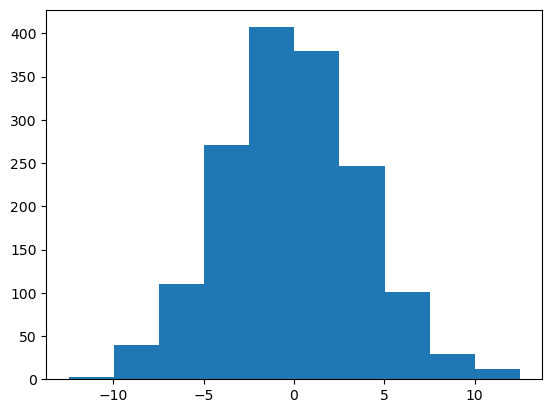

In [371]:
plt.hist(theta)

13.333333333333334